## Import and Install Required Libraries

In [ ]:
%pip install pandas
%pip isntall torch torchvision
%pip isntall d2l

In [2]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

# Dataset Loading

In [3]:
# Data Hub configuration
d2l.DATA_HUB['cifar10_tiny'] = (
    d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
    '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd'
)

# Download and extract the CIFAR-10 dataset
data_dir = d2l.download_extract('cifar10_tiny')

## Utility Functions

In [4]:
def read_csv_labels(fname):
    """Read fname to return a name to label dictionary."""
    with open(fname, 'r') as f:
        lines = f.readlines()[1:]  # Skip the file header line (column name)
    tokens = [l.rstrip().split(',') for l in lines]
    return dict((name, label) for name, label in tokens)

def copyfile(filename, target_dir):
    """Copy a file into a target directory."""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

def reorg_train_valid(data_dir, labels, valid_ratio):
    n = collections.Counter(labels.values()).most_common()[-1][1]
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train', label))
    return n_valid_per_label

def reorg_test(data_dir):
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))

def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

## Training and Validation Data Preparation

In [8]:
batch_size = 4
valid_ratio = 0.25
reorg_cifar10_data(data_dir, valid_ratio)

# Data augmentation and normalization for training and validation
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(40),
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0), ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

# Dataset and DataLoader setup
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False, drop_last=True)
test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False, drop_last=False)

# Model Building

In [14]:
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes, 3)
    return net

loss = nn.CrossEntropyLoss(reduction="none")

# Training the Model

In [9]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'valid acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[2], metric[1] / metric[2], None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    if valid_iter is not None:
        print(f'loss {metric[0] / metric[2]:.3f}, train acc {metric[1] / metric[2]:.3f}, valid acc {valid_acc:.3f}')
    else:
        print(f'loss {metric[0] / metric[2]:.3f}, train acc {metric[1] / metric[2]:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(devices)}')

## Training and Evaluation - First test

loss 1.558, train acc 0.423, valid acc 0.510
195.8 examples/sec on [device(type='cuda', index=0)]


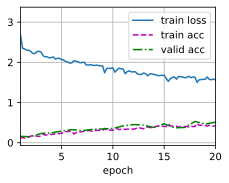

In [15]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 0.001, 5e-4
lr_period, lr_decay, net = 50, 0.1, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

## Second Test

loss 1.091, train acc 0.632, valid acc 0.750
193.7 examples/sec on [device(type='cuda', index=0)]


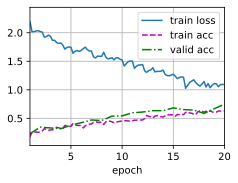

In [17]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 0.0001, 5e-4
lr_period, lr_decay, net_2 = 50, 0.01, get_net()
train(net_2, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

## Third Test

loss 0.462, train acc 0.842, valid acc 0.812
192.7 examples/sec on [device(type='cuda', index=0)]


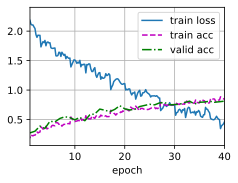

In [18]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 40, 0.0001, 5e-4
lr_period, lr_decay, net_2 = 50, 0.001, get_net()
train(net_2, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

## Save the Model

In [23]:
model_path = "./model/cifar10_resnet18.pth"
torch.save(net_2.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to ./model/cifar10_resnet18.pth


## Label Map

In [13]:
train_valid_ds.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']